In [1]:
#Imports
from matplotlib import rcParams 
from matplotlib import pyplot as plt

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
#Import local Data

alldat = np.array([])
for j in range(3):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))
    
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [3]:
dat = alldat[11]

vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

In [67]:
dat['spks'].shape

#Neuron, Trial, Time

(698, 340, 250)

In [114]:
average_HZ = np.zeros_like(dat['spks'].mean(axis=2).T) #create an array with shape n_Trial, n_Neuron

start_idx = ((dat['gocue'] * 1/dat['bin_size']).astype(int)).squeeze() # from go cue time get the index of the first bin 
stop_idx = ((dat['response_time'] * 1/dat['bin_size']).astype(int)).squeeze() # from the response time get the index of the last bin
# Example: If gue_cue  = 0.71 there where 710 ms before the cue was played
# since one bin equals to 10ms we need the first 71 bins
# -> int(gue_cue * 1 / bin_size) = 71 -> first 71 idices

for i, start in enumerate(start_idx):
    average_HZ[i, :] =  dat['spks'][:, index, :stop_idx[i]].mean(axis=1) #average the over time to get average fiering rate
    
    
average_HZ = average_HZ[np.nonzero(dat['response'])] #Filter out Trials with no response
average_HZ.shape
#n_Trial, n_Neuron

(276, 698)

In [115]:
response = dat['response'][np.nonzero(dat['response'])] # Get the response (the direction chosen by the mouse)

In [116]:
log_reg = LogisticRegression(penalty="l2")
log_reg.fit(average_HZ, response)
response_prediction = log_reg.predict(average_HZ)

In [117]:
def compute_accuracy(X, y, model):
    """Compute accuracy of classifier predictions.

    Args:
        X (2D array): Data matrix
        y (1D array): Label vector
        model (sklearn estimator): Classifier with trained weights.

    Returns:
        accuracy (float): Proportion of correct predictions.
    """

    y_pred = model.predict(X)
 

    accuracy = np.sum(y_pred == y) / len(y)

    return accuracy


# Compute train accurcy
train_accuracy = compute_accuracy(average_HZ, response, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 56.52%


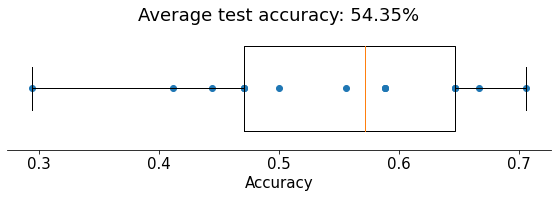

In [119]:
k_fold = 16

accuracies = cross_val_score(LogisticRegression(penalty='l2', C=100,max_iter=5000), average_HZ, response, cv=k_fold)

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(k_fold))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

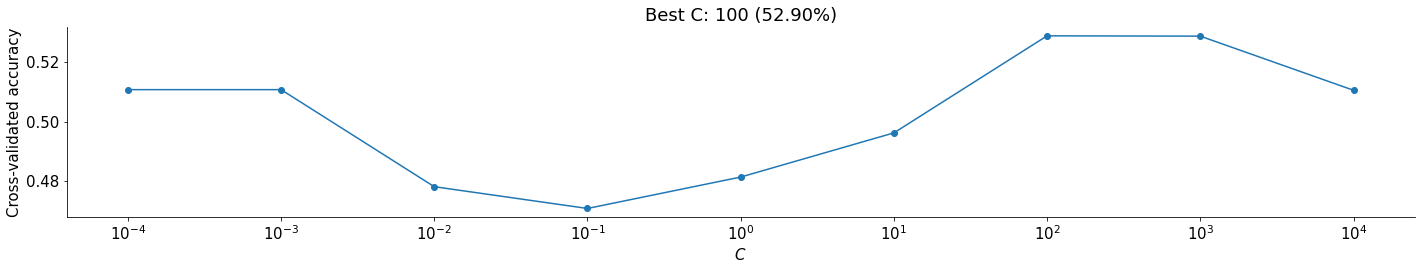

In [43]:
def model_selection(X, y, C_values):
    """Compute CV accuracy for each C value.
    Args:
        X (2D array): Data matrix
        y (1D array): Label vector
        C_values (1D array): Array of hyperparameter values.
    Returns:
        accuracies (1D array): CV accuracy with each value of C.
    """
    accuracies = []
    for C in C_values:

        # Initialize and fit the model
        # (Hint, you may need to set max_iter)
        model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

        # Get the accuracy for each test split using cross-validation
        accs = cross_val_score(model, X, y, cv=8)

        # Store the average test accuracy for this value of C
        accuracies.append(accs.mean())

    return accuracies


def plot_model_selection(C_values, accuracies):
    """Plot the accuracy curve over log-spaced C values."""
    ax = plt.figure().subplots()
    ax.set_xscale("log")
    ax.plot(C_values, accuracies, marker="o")
    best_C = C_values[np.argmax(accuracies)]
    ax.set(
        xticks=C_values,
        xlabel="$C$",
        ylabel="Cross-validated accuracy",
        title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
        )

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

# Compute accuracies
accuracies = model_selection(average_HZ, response, C_values)

# Visualize

plot_model_selection(C_values, accuracies)

In [ ]:
# Only use a part of the neurons, look at different regions
# Look at the History of the experiments, maybe they have impact
# Only look at trials with a long reaction time / low weel movement during the desicion making process.